In [2]:
#Imports & declarations
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as st
from pathlib import Path
from sklearn import datasets, linear_model
import hvplot.pandas
import requests
import json
from pprint import pprint
import hvplot.pandas
# Import the API key
#from config import geoapify_key


In [17]:
#Path CSV data
sea_levels_path = 'Resources/cleanedsealevel.csv'
migration = 'Resources/census-county-to-county-migration.csv'
censuspop = 'Resources/census-population.xlsx'
zillow = 'Resources/zprop.csv'
odnpop = 'Resources/ODN_Population_20240129.csv'
weather = 'Resources/weather.csv'
inflation = 'Resources/DP_LIVE_04022024012624347.csv'

In [18]:
#Read CSVs into Dataframes
sea_levels= pd.read_csv(sea_levels_path)
migrations= pd.read_csv(migration)
pvals = pd.read_csv(zillow)
pop = pd.read_csv(odnpop)
wtemp = pd.read_csv(weather)
infl = pd.read_csv(inflation)

In [19]:
#Information:
#https://www.zillow.com/research/data/
#Home Values (Single Family Homes) sorted geographically by county
pvals

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,StateCodeFIPS,MunicipalCodeFIPS,2000-01-31,...,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31
0,3101,0,Los Angeles County,county,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",6,37,208453.080524,...,804802.541310,801021.907927,803549.432152,810316.308955,821345.498959,834884.912014,848342.362212,859321.896663,867528.209805,872695.048413
1,139,1,Cook County,county,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",17,31,146516.213789,...,289927.709298,291803.759952,293392.842156,295102.848442,297014.709471,299235.790651,300970.253144,302316.658271,303244.721991,303884.658933
2,1090,2,Harris County,county,TX,TX,"Houston-The Woodlands-Sugar Land, TX",48,201,109838.425455,...,279006.326508,278393.382584,278375.563868,279008.874039,279781.713606,280585.152352,280917.629885,280960.340996,280717.100572,280439.814641
3,2402,3,Maricopa County,county,AZ,AZ,"Phoenix-Mesa-Chandler, AZ",4,13,144914.772450,...,454472.317136,453596.967878,454557.524068,456670.719212,459517.807325,462532.532365,465036.625805,467246.154538,469054.475581,470036.354079
4,2841,4,San Diego County,county,CA,CA,"San Diego-Chula Vista-Carlsbad, CA",6,73,224488.557842,...,870406.450342,874328.164080,881971.721215,892253.850546,904473.400076,917054.125155,929238.112429,939224.545274,946028.121656,949603.992802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3071,846,3206,Banner County,county,NE,NE,"Scottsbluff, NE",31,7,NaN,...,286495.485328,288963.144908,293404.646124,297982.937945,303221.568679,308324.293100,312531.028460,316194.328152,318241.617684,318700.497331
3072,1648,3207,Daggett County,county,UT,UT,NaN,49,9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,307588.203336,306735.806453,306030.886931
3073,1432,3208,Thomas County,county,NE,NE,NaN,31,171,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,129634.834614,129173.045077
3074,2794,3212,McPherson County,county,NE,NE,"North Platte, NE",31,117,NaN,...,238631.791013,239907.502218,243713.320855,247472.453259,251510.668543,255606.446130,259303.491520,262310.137508,264384.559066,266216.985756


In [20]:
#Selecting counties of interest from Zillow data
nccount = pvals.loc[pvals['RegionName'].isin(['Hyde County', 'Dare County', 'Carteret County'])]
nccount
# Melt to reorganize data, specifically date to column, then remove unwanted rows.
# Convert Datetimes to just year values
ncvals = nccount.melt(id_vars=["RegionName", "StateName"], 
        var_name="Date", 
        value_name="Value")
ncvals = ncvals[ncvals.Date != 'RegionID']
ncvals = ncvals[ncvals.Date != 'SizeRank']
ncvals = ncvals[ncvals.Date != 'RegionType']
ncvals = ncvals[ncvals.Date != 'State']
ncvals = ncvals[ncvals.Date != 'Metro']
ncvals = ncvals[ncvals.Date != 'StateCodeFIPS']
ncvals = ncvals[ncvals.Date != 'MunicipalCodeFIPS']
ncvals = ncvals[ncvals.Date != 'NaN']
ncpval = ncvals.dropna()
ncpval['Year'] =  pd.DatetimeIndex(ncpval['Date']).year

#Make a copy with just selected columns
ncpvalclean = ncpval[['RegionName', 'Year', 'Value']].copy()

ncpvalclean


C:\Users\trist\AppData\Local\Temp\ipykernel_31908\3296963289.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ncpval['Year'] =  pd.DatetimeIndex(ncpval['Date']).year


,RegionName,Year,Value
21,Carteret County,2000,142161.979276
24,Carteret County,2000,142001.458621
27,Carteret County,2000,142290.027754
30,Carteret County,2000,142874.522973
31,Dare County,2000,215339.290569
...,...,...,...
880,Dare County,2023,589182.20271
881,Hyde County,2023,228859.267823
882,Carteret County,2023,435713.676949
883,Dare County,2023,590238.182811


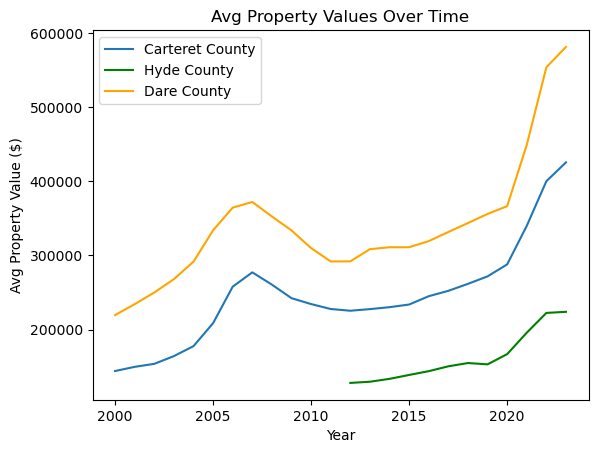

In [21]:
#Gather average property value for all 3 counties for each year to plot trends 
avgall = ncpvalclean.groupby('Year')['Value'].mean()
avgall
avgyear = ncpvalclean['Year'].unique()
#plt.plot(avgyear, avgall, label = 'All Avg')
cpval = ncpvalclean.loc[(ncpvalclean['RegionName']=='Carteret County')]
cpvals = cpval.groupby(['Year'])['Value'].mean()
cpvals.to_frame()
cpvals.reset_index()
plotcv = cpvals.plot(x ='Year', y='Value', label = 'Carteret County')
hpval = ncpvalclean.loc[(ncpvalclean['RegionName']=='Hyde County')]
hpvals = hpval.groupby(['Year'])['Value'].mean()
hpvals.to_frame()
hpvals.reset_index()
plothv = hpvals.plot(x ='Year', y='Value', label = 'Hyde County', color = 'g')
dpval = ncpvalclean.loc[(ncpvalclean['RegionName']=='Dare County')]
dpvals = dpval.groupby(['Year'])['Value'].mean()
dpvals.to_frame()
dpvals.reset_index()
plotdv = dpvals.plot(x ='Year', y='Value', label = 'Dare County', color = 'orange')
hpvals
plotdv.set_xlabel('Year')
plotdv.set_ylabel('Avg Property Value ($)')
plt.title('Avg Property Values Over Time')
plt.legend()


In [22]:
#Considering an inflation calculation, https://www.bls.gov/data/inflation_calculator.htm gives the dollar a x1.82 value from 2000 to today.
#https://data.oecd.org/price/inflation-cpi.htm#indicator-chart provides a CPI Rate by year for relevant years

#Merging CPI inflation data with Zillow property values for the selected counties
#Creates a new inflation-adjusted value in order to see trends in property value not based on inflation alone
infl
inf = infl[['TIME', 'Value']].copy()
inf
Zillowpval = avgall.to_frame()
inf.rename(columns = {'TIME':'Year'}, inplace = True) 
inf.rename(columns = {'Value':'CPI Rate'}, inplace = True) 
inf
Zillowpval.reset_index()
pvalinfl = pd.merge(inf, Zillowpval, on = 'Year')
pvalinfl
#real price of a good = (nominal price of a good/CPI) x 100
#pvalinfl['Adjusted Value'] = ((pvalinfl['Value'] * pvalinfl['CPI Rate']) / 100)
#pvalinfl['Adjusted Val'] = ((pvalinfl['Value'] * pvalinfl['CPI Rate']))
pvalinfl['%CPI'] = ((pvalinfl['CPI Rate'] / 100))
pvalinfl['Adjusted Vals'] = ((pvalinfl['Value'] * pvalinfl['%CPI']) + pvalinfl['Value'])



pvalinfl

,Year,CPI Rate,Value,%CPI,Adjusted Vals
0,2000,3.376857,176324.107984,0.033769,182278.320967
1,2000,4.067432,176324.107984,0.040674,183495.971175
2,2001,2.826171,191918.909669,0.028262,197342.866238
3,2001,3.675175,191918.909669,0.036752,198972.265458
4,2002,1.586032,201816.094129,0.015860,205016.961963
5,2002,2.783710,201816.094129,0.027837,207434.068923
6,2003,2.270095,216055.132264,0.022701,220959.789019
7,2003,2.484033,216055.132264,0.024840,221422.013047
8,2004,2.677237,234594.76269,0.026772,240875.420477
9,2004,2.416745,234594.76269,0.024167,240264.319888


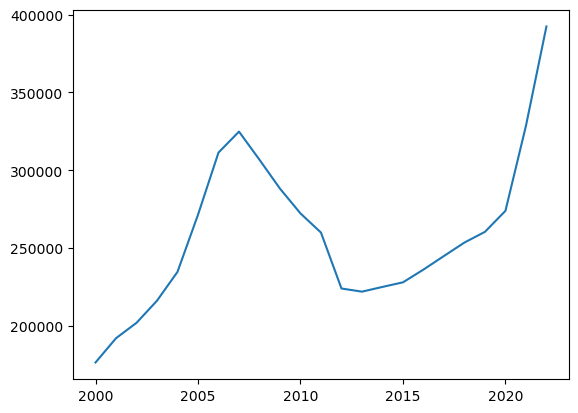

In [23]:
plt.plot(pvalinfl['Year'], pvalinfl['Value'])


In [24]:
#Info provided on documentation:
#https://tidesandcurrents.noaa.gov/sltrends/sltrends_station.shtml?id=8652587
#Data collected by NOAA Station 8652587, Oregon Inlet Marina, North Carolina.
#Monthly mean sea levels with the average seasonal cycle removed. 
#The values are in meters relative to the most recent Mean Sea Level datum established by CO-OPS.
#Column values are the Year; Month; Monthly Mean; Relative Sea Level Trend Line; Higher 95% Confidence Interval; and Lower 95% Confidence Interval.
sea_levels


,Year,Month,Monthly_MSL,Linear_Trend,High_Conf.,Low_Conf.
0,1977,5,-0.109,-0.082,-0.049,-0.114
1,1977,6,-0.032,-0.081,-0.049,-0.114
2,1977,7,-0.100,-0.081,-0.048,-0.113
3,1977,8,-0.053,-0.080,-0.048,-0.113
4,1977,9,-0.077,-0.080,-0.048,-0.112
...,...,...,...,...,...,...
364,2023,7,0.217,0.168,0.188,0.149
365,2023,8,0.152,0.169,0.188,0.149
366,2023,9,0.221,0.169,0.189,0.150
367,2023,10,0.224,0.170,0.189,0.150


Year
 Month
 Monthly_MSL
 Linear_Trend
 High_Conf.
 Low_Conf.


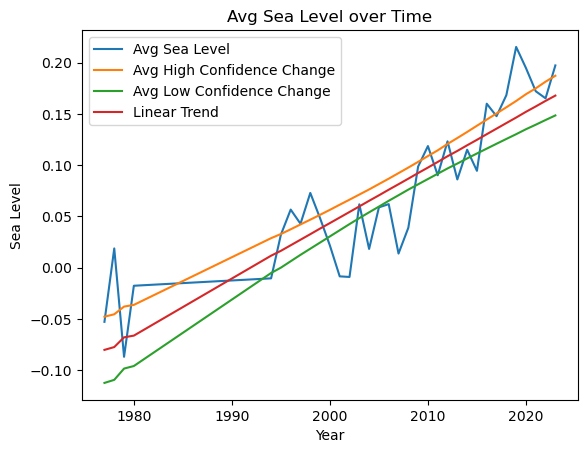

In [25]:
#To get column keys- note space before all but 'Year' column
from importlib import reload
plt=reload(plt)

for col in sea_levels.columns:
    print(col)
yavgsea = sea_levels.groupby('Year')[' Monthly_MSL'].mean()
yavghc = sea_levels.groupby('Year')[' High_Conf.'].mean()
yavglc = sea_levels.groupby('Year')[' Low_Conf.'].mean()
yavglt = sea_levels.groupby('Year')[' Linear_Trend'].mean()

yearssea = sea_levels['Year'].unique()
plt.xlabel('Year')
plt.ylabel('Sea Level')
plt.plot(yearssea, yavgsea, label = 'Avg Sea Level')
plt.plot(yearssea, yavghc, label = 'Avg High Confidence Change')
plt.plot(yearssea, yavglc, label = 'Avg Low Confidence Change')
plt.plot(yearssea, yavglt, label = 'Linear Trend')
plt.title('Avg Sea Level over Time')
plt.legend()

In [26]:
#Migration Data
census = Path("Resources/census_county.csv")
census_df = pd.read_csv(census)

reduced_census = census_df[["Area Name", "Year", "Net Migration"]]

cleaned_df = reduced_census.loc[(census_df['Area Name']=='Carteret County') | 
                                 (census_df['Area Name']=='Dare County')| 
                                 (census_df['Area Name']=='Hyde County')]


cleaned_df


,Area Name,Year,Net Migration
285,Carteret County,2017,-9.0
286,Carteret County,2017,-35.0
287,Carteret County,2017,-90.0
288,Carteret County,2017,2.0
289,Carteret County,2017,1.0
...,...,...,...
192326,Hyde County,2020,-6.0
192327,Hyde County,2020,14.0
192328,Hyde County,2020,4.0
192329,Hyde County,2020,1.0


In [27]:
#Merge to look for trends in sea level and migration 
seaandmigration = pd.merge(sea_levels,cleaned_df, on= 'Year')
seaandmigration
#for col in seaandmigration:
#    print(col)

,Year,Month,Monthly_MSL,Linear_Trend,High_Conf.,Low_Conf.,Area Name,Net Migration
0,2010,1,0.158,0.095,0.106,0.084,Carteret County,27.0
1,2010,1,0.158,0.095,0.106,0.084,Carteret County,-67.0
2,2010,1,0.158,0.095,0.106,0.084,Carteret County,-42.0
3,2010,1,0.158,0.095,0.106,0.084,Carteret County,-6.0
4,2010,1,0.158,0.095,0.106,0.084,Carteret County,-4.0
...,...,...,...,...,...,...,...,...
53242,2020,12,0.207,0.154,0.172,0.137,Hyde County,-6.0
53243,2020,12,0.207,0.154,0.172,0.137,Hyde County,14.0
53244,2020,12,0.207,0.154,0.172,0.137,Hyde County,4.0
53245,2020,12,0.207,0.154,0.172,0.137,Hyde County,1.0


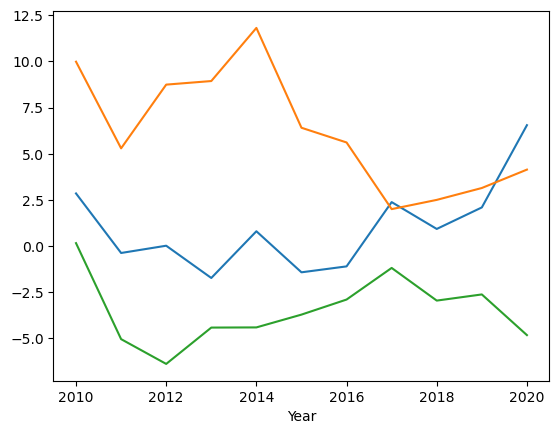

In [28]:
#Plotting 
meanmigr = seaandmigration.groupby(['Year'])['Net Migration'].mean()
meanhc = seaandmigration.groupby('Year')[' High_Conf.'].mean()
avgdf = meanmigr.to_frame()
avgdf1 = meanhc.to_frame()


avgsdf = pd.merge(avgdf,avgdf1, on='Year')
avgsdf.reset_index(inplace=True)
avgsdf

cmigr = seaandmigration.loc[(seaandmigration['Area Name']=='Carteret County')]
cartmigr = cmigr.groupby(['Year'])['Net Migration'].mean()
cartmigr.to_frame()
cartmigr.reset_index()
plot3 = cartmigr.plot(x ='Year', y='Net Migration')
hmigr = seaandmigration.loc[(seaandmigration['Area Name']=='Hyde County')]
hydmigr = hmigr.groupby(['Year'])['Net Migration'].mean()
hydmigr.to_frame()
hydmigr.reset_index()
plot4 = hydmigr.plot(x ='Year', y='Net Migration')
dmigr = seaandmigration.loc[(seaandmigration['Area Name']=='Dare County')]
darmigr = dmigr.groupby(['Year'])['Net Migration'].mean()
darmigr.to_frame()
darmigr.reset_index()
plot4 = darmigr.plot(x ='Year', y='Net Migration')


In [29]:
pop

,id,name,type,variable,value,year
0,0100000US,United States,nation,count,3.115366e+08,2013
1,0100000US,United States,nation,change,7.760000e-01,2013
2,0100000US,United States,nation,count,3.091387e+08,2012
3,0100000US,United States,nation,change,8.270000e-01,2012
4,0100000US,United States,nation,count,3.066038e+08,2011
...,...,...,...,...,...,...
1195273,310M200US19700,"Deming, NM Micro Area",msa,change,-2.261606e-01,2018
1195274,310M200US19740,"Denver-Aurora-Lakewood, CO Metro Area",msa,change,1.841473e+00,2018
1195275,310M200US19760,"DeRidder, LA Micro Area",msa,change,4.672386e-01,2018
1195276,310M200US19780,"Des Moines-West Des Moines, IA Metro Area",msa,change,1.779453e+00,2018


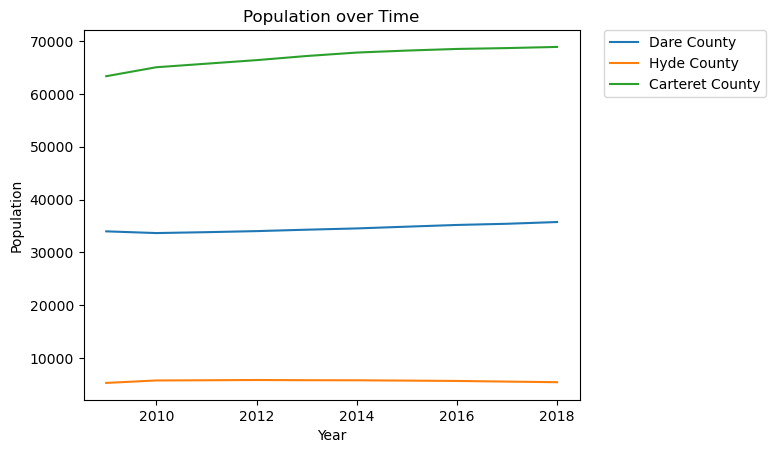

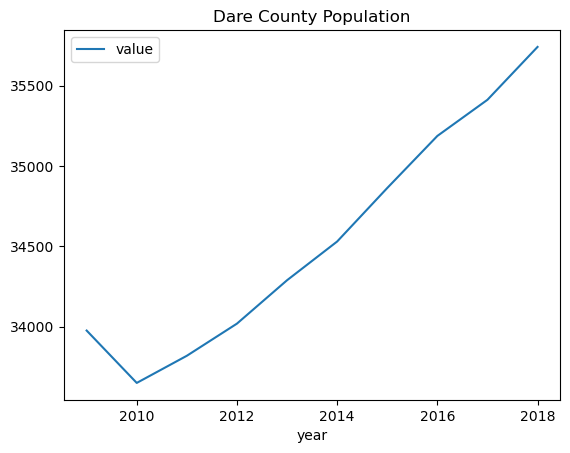

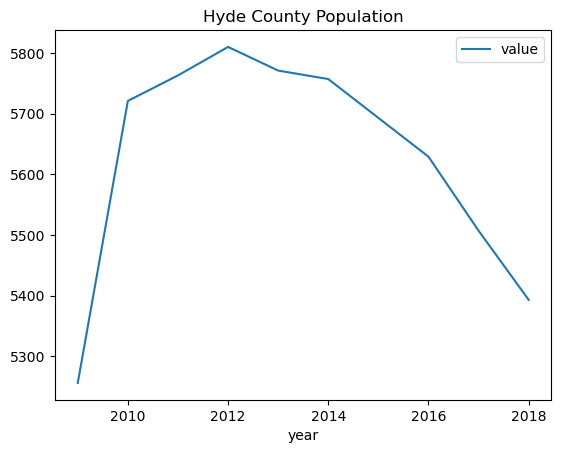

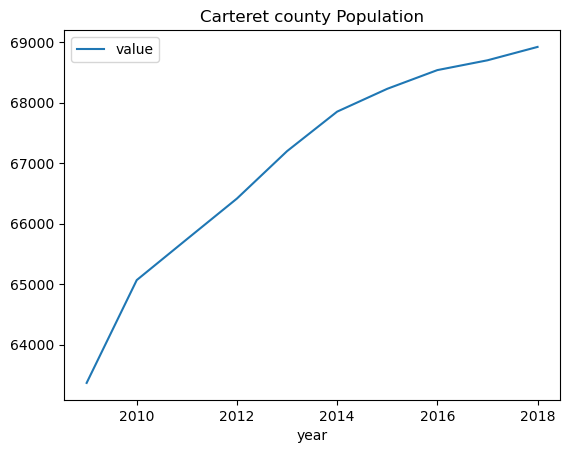

In [30]:
#Population trends cleaned from Census data for individual counties
pop1 = pop.loc[(pop['type']=='county') ] 
pop2 = pop1.loc[(pop1['name']=='Carteret County, North Carolina') | 
                                 (pop1['name']=='Dare County, North Carolina')| 
                                 (pop1['name']=='Hyde County, North Carolina')]
pop2
pop3 = pop2.loc[(pop2['variable']== 'count')]
cleanpop = pop3.groupby(['year'])['value'].mean()
darepop = pop3.loc[(pop3['name']=='Dare County, North Carolina')]
hydepop = pop3.loc[(pop3['name']=='Hyde County, North Carolina')]
cartpop =pop3.loc[(pop3['name']=='Carteret County, North Carolina')]
pop3.sort_values('year')
plt = reload(plt)

dpop = darepop.sort_values('year')
hpop = hydepop.sort_values('year')
cpop = cartpop.sort_values('year')
plt.xlabel('Year')
plt.ylabel('Population')
plt.plot(dpop['year'], dpop['value'], label = 'Dare County')
plt.plot(hpop['year'], hpop['value'], label = 'Hyde County')
plt.plot(cpop['year'], cpop['value'], label = 'Carteret County')
plt.title('Population over Time')
plt.legend(loc='upper right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plotd = dpop.plot(x='year', y='value', title = 'Dare County Population')
ploth = hpop.plot(x='year', y='value', title = 'Hyde County Population')
plotc = cpop.plot(x='year', y='value', title = 'Carteret county Population')



In [31]:
# Target city
target_county1 = "Carteret County"
target_county2 = "Dare County"
target_county3 = "Hyde County"

# Build the endpoint URL
target_url1 = f"https://api.geoapify.com/v1/geocode/search?text={target_county1}&format=json&apiKey={geoapify_key}"
target_url2 = f"https://api.geoapify.com/v1/geocode/search?text={target_county2}&format=json&apiKey={geoapify_key}"
target_url3 = f"https://api.geoapify.com/v1/geocode/search?text={target_county3}&format=json&apiKey={geoapify_key}"

NameError: name 'geoapify_key' is not defined

In [ ]:
# Run a request to endpoint and convert result to json

geo_data1 = requests.get(target_url1).json()
geo_data2 = requests.get(target_url2).json()
geo_data3 = requests.get(target_url3).json()
# Print the json
pprint(geo_data1)
pprint(geo_data2)
pprint(geo_data3)

In [ ]:
# Extract latitude and longitude
lat1 = geo_data1['results'][0]['lat']
lon1 = geo_data1['results'][0]['lon']

lat2 = geo_data2['results'][0]['lat']
lon2 = geo_data2['results'][0]['lon']

lat3 = geo_data3['results'][0]['lat']
lon3 = geo_data3['results'][0]['lon']

# Print the latitude and longitude
print("""
    County: {0}
    Latitude: {1}
    Longitude: {2}
    """.format(target_county1, lat1, lon1))

print("""
    County: {0}
    Latitude: {1}
    Longitude: {2}
    """.format(target_county2, lat2, lon2))

print("""
    County: {0}
    Latitude: {1}
    Longitude: {2}
    """.format(target_county3, lat3, lon3))

In [ ]:
coordinates = {
    "latitude": [lat1, lat2, lat3],
    "longitude": [lon1, lon2, lon3],
    "County": ["Carteret County", "Dare County", "Hyde County"],
    
}

In [ ]:
# Create a Pandas DataFrame containing coordinates
coordinates_df = pd.DataFrame(coordinates)

# Display sample data
coordinates_df

In [ ]:
# Configure the map 
map_plot_1 = coordinates_df.hvplot.points(
    'longitude', 
    'latitude', 
    geo=True,
    tiles='OSM',
    frame_width=700,
    frame_height=600,
    scale= 0.01,
    color='County')

# Display the map 
map_plot_1

In [32]:
hurricanes_hyde = pd.read_csv("Resources/HurricanesHydeCounty1985to2020.csv")

hurricane_df = hurricanes_hyde
hurricane_df

,Name\tDate\tMax Speed Wind
0,Ana\t5/10/2015\t57
1,Claudette\t7/15/2015\t50
2,Arthur\t7/4/2014\t95
3,Beryl\t5/28/2012\t70
4,Irene\t8/28/2011\t115
5,TS One\t5/30/2009\t40
6,Hanna\t9/6/2008\t85
7,Cristobal\t7/23/2008\t65
8,barry\t6/2/2007\t60
9,Gabrielle\t9/9/2007\t60


In [33]:

# Specify the columns for the x and y axes
x_column = "Date"
y_column = "Max Speed Wind"

# Set the size of the figure
plt.figure(figsize=(15, 6))

# Plot the bar graph
plt.bar(hurricane_df[x_column], hurricane_df[y_column])

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right")

plt.xlabel('Date')
plt.ylabel('Max Wind Speed')
plt.title('Hurricane Wind Speed by Date Affecting Hyde County')

plt.show()

KeyError: 'Date'

<Figure size 1500x600 with 0 Axes>

In [3]:
data = pd.read_csv("Resources/Ocracoke.csv")

ocracoke_csv = data[["DATE","PRCP"]]
ocracoke_csv

#new_data = rainfall_df.groupby(['DATE'])['PRCP'].sum()
#new_data

,DATE,PRCP
0,1957-05-16,0.0
1,1957-05-17,0.0
2,1957-05-18,0.0
3,1957-05-19,58.0
4,1957-05-20,69.0
...,...,...
14420,2024-01-24,0.0
14421,2024-01-25,0.0
14422,2024-01-26,5.0
14423,2024-01-27,0.0


C:\Users\trist\AppData\Local\Temp\ipykernel_7412\3093764252.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ocracoke_csv[x_column] = pd.to_datetime(ocracoke_csv[x_column])


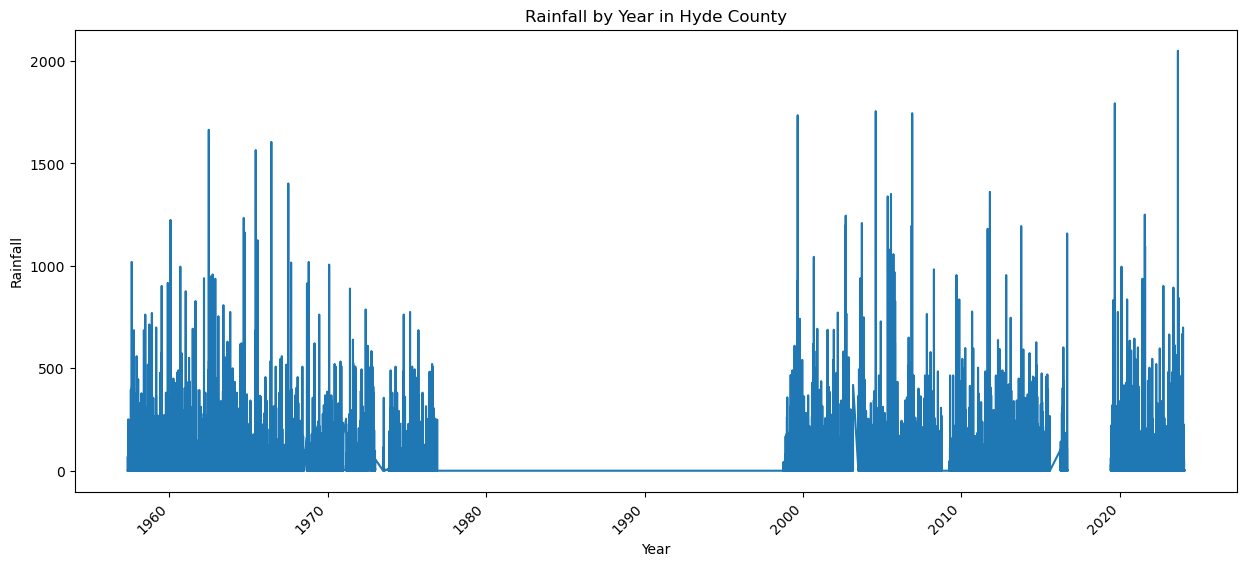

In [4]:
# Specify the columns for the x and y axes
x_column = 'DATE'
y_column = 'PRCP'

# Set the size of the figure
plt.figure(figsize=(15, 6))

# Convert 'DATE' column to datetime format
ocracoke_csv[x_column] = pd.to_datetime(ocracoke_csv[x_column])

# Plot the line graph
plt.plot(ocracoke_csv[x_column], ocracoke_csv[y_column])

# Use YearLocator to set x-axis ticks to display every year
#plt.gca().xaxis.set_major_locator(YearLocator())

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right")

plt.xlabel('Year')
plt.ylabel('Rainfall')
plt.title('Rainfall by Year in Hyde County')
plt.show()

In [5]:
from matplotlib.dates import YearLocator
# Study data files
migpath = "Resources/migration.csv"
census_df = pd.read_csv(migpath)
reduced_census = census_df[["Area Name", "Year", "Net Migration"]]
reduced_census

,Area Name,Year,Net Migration
0,Alamance County,2017,-9.0
1,Alamance County,2017,-15.0
2,Alamance County,2017,2.0
3,Alamance County,2017,-3.0
4,Alamance County,2017,15.0
...,...,...,...
193440,Yancey County,2020,15.0
193441,Yancey County,2020,11.0
193442,Yancey County,2020,15.0
193443,Yancey County,2020,130.0


In [6]:
cleaned_df = reduced_census.loc[(census_df['External Area']=='North Carolina') &
                                (census_df['Area Name']=='Carteret County') | 
                                (census_df['External Area']=='North Carolina') &
                                (census_df['Area Name']=='Dare County')| 
                                (census_df['External Area']=='North Carolina') &
                                (census_df['Area Name']=='Hyde County')]



cleaned_df

,Area Name,Year,Net Migration
295,Carteret County,2017,-25.0
296,Carteret County,2017,-26.0
297,Carteret County,2017,11.0
298,Carteret County,2017,8.0
299,Carteret County,2017,1.0
...,...,...,...
191892,Dare County,2020,-145.0
191893,Dare County,2020,5.0
192327,Hyde County,2020,14.0
192328,Hyde County,2020,4.0


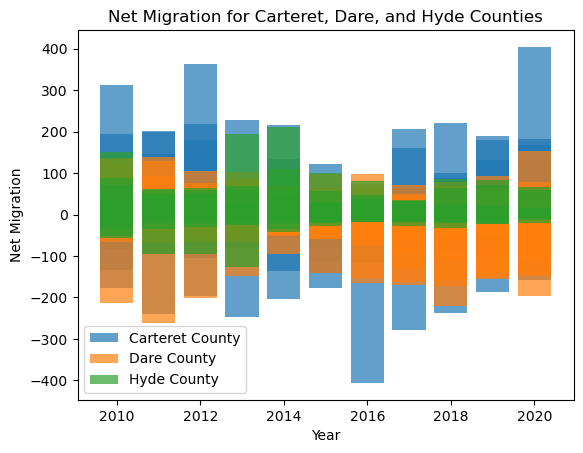

In [7]:
import matplotlib.pyplot as plt


x_column = 'Year'
y_column = 'Net Migration'


grouped_df = cleaned_df.groupby('Area Name')

# Plotting the bar graph for each county with different bar colors
for name, group in grouped_df:
    plt.bar(group[x_column], group[y_column], label=name, alpha=0.7)

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Net Migration')
plt.title('Net Migration for Carteret, Dare, and Hyde Counties')
plt.legend()  # Display legend with county names

# Display the plot
plt.show()

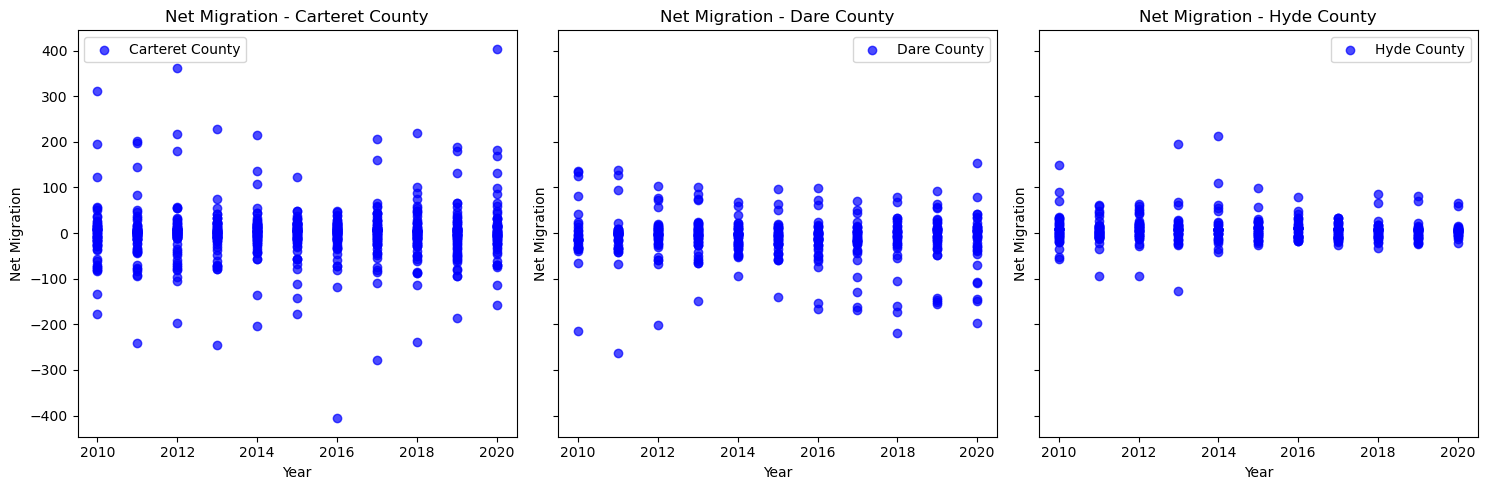

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator

# Study data files
migpath = "Resources/migration.csv"
census_df = pd.read_csv(migpath)
reduced_census = census_df[["Area Name", "Year", "Net Migration"]]
x_column = 'Year'
y_column = 'Net Migration'
cleaned_df = reduced_census.loc[(census_df['External Area']=='North Carolina') &
                                (census_df['Area Name']=='Carteret County') | 
                                (census_df['External Area']=='North Carolina') &
                                (census_df['Area Name']=='Dare County')| 
                                (census_df['External Area']=='North Carolina') &
                                (census_df['Area Name']=='Hyde County')]

grouped_df = cleaned_df.groupby('Area Name')

# Create subplots for each county
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)

# Plotting scatterplot for each county
for i, (name, group) in enumerate(grouped_df):
    axs[i].scatter(group[x_column], group[y_column], label=name, alpha=0.7, color='b')

    # Adding labels and title for each subplot
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('Net Migration')
    axs[i].set_title(f'Net Migration - {name}')
    axs[i].legend()

# Adjust layout to prevent clipping of ylabel
plt.tight_layout()

# Display the plots
plt.show()

In [10]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

census = Path("Resources/census_county.csv", inex_col='Area Name')

# Read in census csv
census_df = pd.read_csv(census)
census_df

# Reduce columns to show only data we want
reduced_census = census_df[["Area Name","External Area", "Year", "Net Migration"]]
reduced_census

,Area Name,External Area,Year,Net Migration
0,Alamance County,Arizona,2017,-9.0
1,Alamance County,California,2017,-15.0
2,Alamance County,Georgia,2017,2.0
3,Alamance County,Iowa,2017,-3.0
4,Alamance County,Massachusetts,2017,15.0
...,...,...,...,...
193440,Yancey County,Montana,2020,15.0
193441,Yancey County,New Jersey,2020,11.0
193442,Yancey County,North Carolina,2020,15.0
193443,Yancey County,North Carolina,2020,130.0


In [11]:
# Locate the three counties that we are focused on
cleaned_df = reduced_census.loc[(census_df['External Area']=='North Carolina') &
                                (census_df['Area Name']=='Carteret County') | 
                                (census_df['External Area']=='North Carolina') &
                                (census_df['Area Name']=='Dare County')| 
                                (census_df['External Area']=='North Carolina') &
                                (census_df['Area Name']=='Hyde County')]


cleaned_df


,Area Name,External Area,Year,Net Migration
295,Carteret County,North Carolina,2017,-25.0
296,Carteret County,North Carolina,2017,-26.0
297,Carteret County,North Carolina,2017,11.0
298,Carteret County,North Carolina,2017,8.0
299,Carteret County,North Carolina,2017,1.0
...,...,...,...,...
191892,Dare County,North Carolina,2020,-145.0
191893,Dare County,North Carolina,2020,5.0
192327,Hyde County,North Carolina,2020,14.0
192328,Hyde County,North Carolina,2020,4.0


In [12]:
# Drop External Area from dataframe
cleaned_2 = cleaned_df.drop('External Area', axis=1)
cleaned_2


,Area Name,Year,Net Migration
295,Carteret County,2017,-25.0
296,Carteret County,2017,-26.0
297,Carteret County,2017,11.0
298,Carteret County,2017,8.0
299,Carteret County,2017,1.0
...,...,...,...
191892,Dare County,2020,-145.0
191893,Dare County,2020,5.0
192327,Hyde County,2020,14.0
192328,Hyde County,2020,4.0


In [13]:

#Use GroupBy area name and year and get sum of Net Migration
new_data = cleaned_2.groupby(['Area Name','Year'])['Net Migration'].sum()
new_data_df = new_data.to_frame()
new_data_df = new_data_df.reset_index()
new_data_df

,Area Name,Year,Net Migration
0,Carteret County,2010,-125.0
1,Carteret County,2011,-182.0
2,Carteret County,2012,155.0
3,Carteret County,2013,-226.0
4,Carteret County,2014,158.0
5,Carteret County,2015,-300.0
6,Carteret County,2016,-578.0
7,Carteret County,2017,7.0
8,Carteret County,2018,-212.0
9,Carteret County,2019,-126.0


Text(0.5, 1.0, 'Net Migration over time')

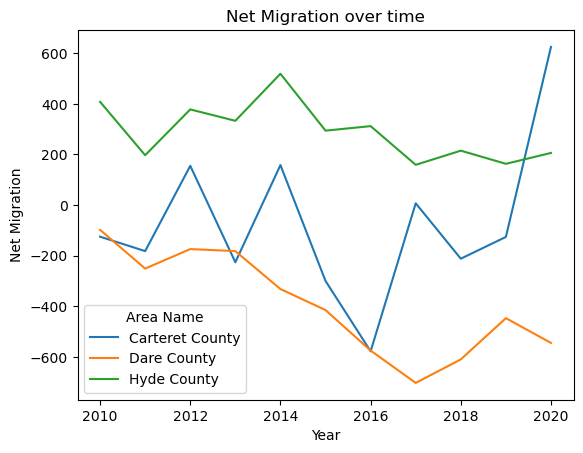

In [14]:
#Plot all three counties 
cleaned_2.groupby(['Year','Area Name'])['Net Migration'].sum().unstack().plot()

plt.ylabel("Net Migration")
plt.title('Net Migration over time')

In [15]:
import os
import csv
import pandas as pd
import pathlib as path
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv("Resources/Ocracoke.csv")
hurricanes = pd.read_csv("Resources/HurricanesDareCounty1985to2020.csv")

rainfall_df = data[["DATE", "PRCP"]]
rainfall_df






,DATE,PRCP
0,1957-05-16,0.0
1,1957-05-17,0.0
2,1957-05-18,0.0
3,1957-05-19,58.0
4,1957-05-20,69.0
...,...,...
14420,2024-01-24,0.0
14421,2024-01-25,0.0
14422,2024-01-26,5.0
14423,2024-01-27,0.0


In [16]:

hurricane_df = hurricanes[["Hurricane", "Date", "Max Wind Speed"]]
hurricane_df

,Hurricane,Date,Max Wind Speed
0,Gloria,9/26/1985,144
1,Kate,11/22/1985,123
2,Bob,8/19/1991,115
3,Emily,8/31/1993,115
4,Bertha,7/13/1996,115
5,Fran,9/10/1996,121
6,Bonnie,8/31/1998,115
7,Earl,9/8/1998,98
8,Dennis,9/14/1999,104
9,Floyd,9/16/1999,155


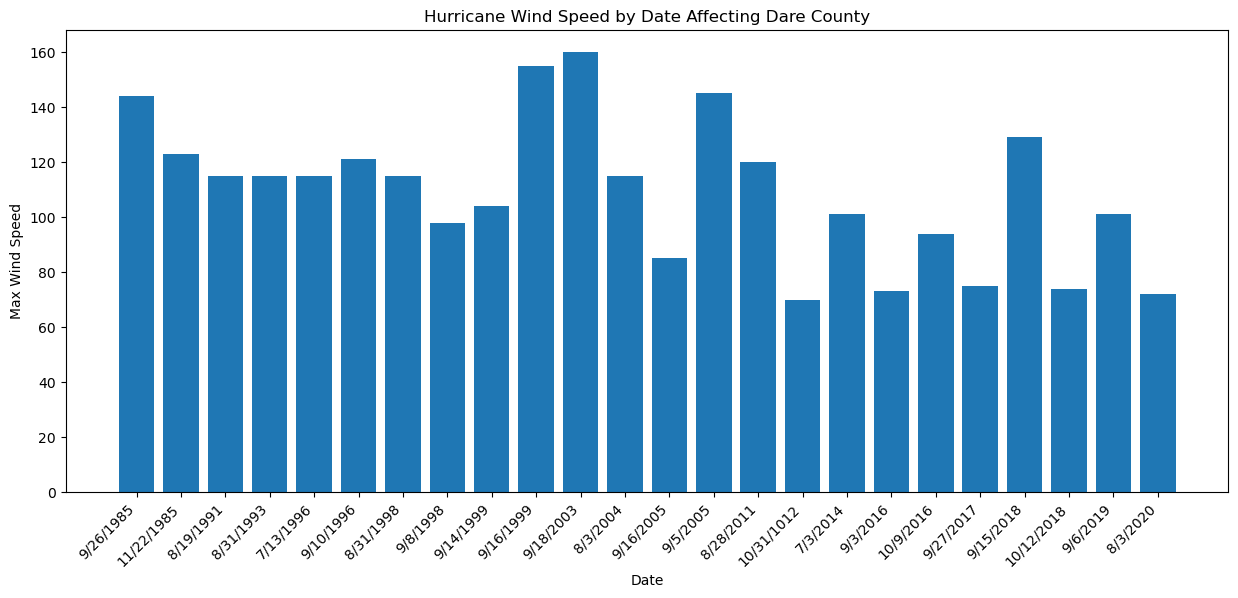

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

hurricanepath = "Resources/HurricanesDareCounty1985to2020.csv"
hurricane_csv = pd.read_csv(hurricanepath)

# Specify the columns for the x and y axes
x_column = "Date"
y_column = "Max Wind Speed"

# Set the size of the figure
plt.figure(figsize=(15, 6))

# Plot the bar graph
plt.bar(hurricane_csv[x_column], hurricane_csv[y_column])

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right")

plt.xlabel('Date')
plt.ylabel('Max Wind Speed')
plt.title('Hurricane Wind Speed by Date Affecting Dare County')

plt.show()

In [19]:
hurricanes_carteret = pd.read_csv("Resources/HurricanesCarteretCounty1985to2020.csv")

hurricane_df = hurricanes[["Hurricane", "Date", "Max Wind Speed"]]
hurricane_df

,Hurricane,Date,Max Wind Speed
0,Gloria,9/26/1985,144
1,Kate,11/22/1985,123
2,Bob,8/19/1991,115
3,Emily,8/31/1993,115
4,Bertha,7/13/1996,115
5,Fran,9/10/1996,121
6,Bonnie,8/31/1998,115
7,Earl,9/8/1998,98
8,Dennis,9/14/1999,104
9,Floyd,9/16/1999,155


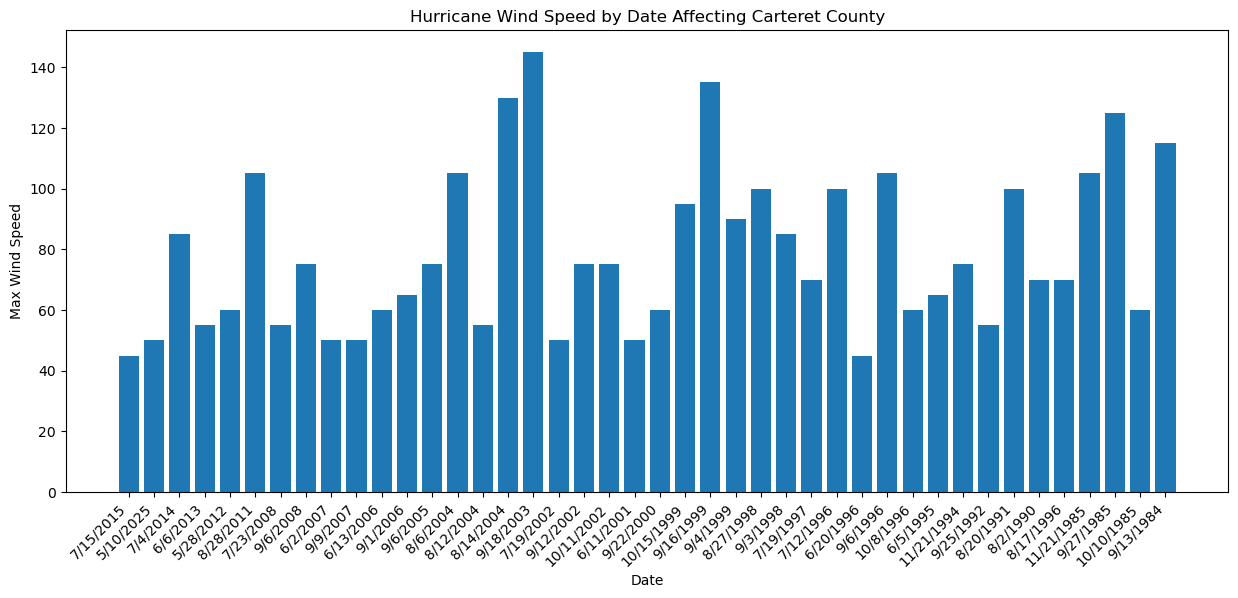

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

hurricanepath_Carteret = "Resources/HurricanesCarteretCounty1985to2020.csv"
hurricane_csv_Carteret = pd.read_csv(hurricanepath_Carteret)

# Specify the columns for the x and y axes
x_column = "Date"
y_column = "Max Wind Speed"

# Set the size of the figure
plt.figure(figsize=(15, 6))

# Plot the bar graph
plt.bar(hurricane_csv_Carteret[x_column], hurricane_csv_Carteret[y_column])

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right")

plt.xlabel('Date')
plt.ylabel('Max Wind Speed')
plt.title('Hurricane Wind Speed by Date Affecting Carteret County')

plt.show()

In [21]:
hurricanes_hyde = pd.read_csv("Resources/HurricanesHydeCounty1985to2020.csv")

hurricane_df = hurricanes[["Hurricane", "Date", "Max Wind Speed"]]
hurricane_df

,Hurricane,Date,Max Wind Speed
0,Gloria,9/26/1985,144
1,Kate,11/22/1985,123
2,Bob,8/19/1991,115
3,Emily,8/31/1993,115
4,Bertha,7/13/1996,115
5,Fran,9/10/1996,121
6,Bonnie,8/31/1998,115
7,Earl,9/8/1998,98
8,Dennis,9/14/1999,104
9,Floyd,9/16/1999,155


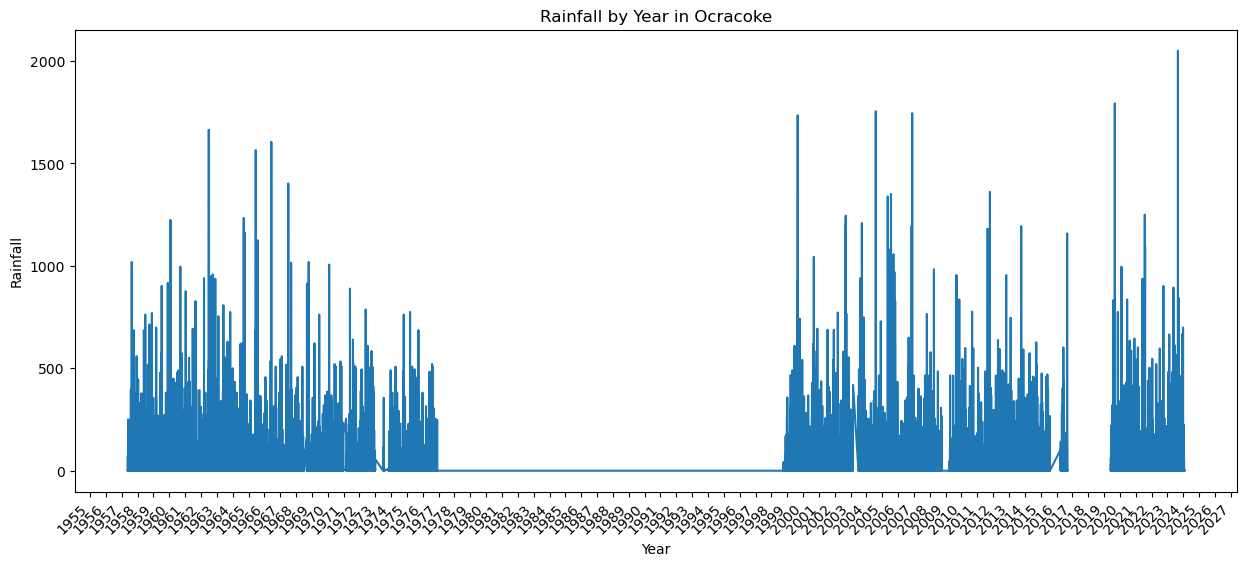

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator

ocracokepath = "Resources/Ocracoke.csv"
ocracoke_csv = pd.read_csv(ocracokepath)

# Specify the columns for the x and y axes
x_column = 'DATE'
y_column = 'PRCP'

# Set the size of the figure
plt.figure(figsize=(15, 6))

# Convert 'DATE' column to datetime format
ocracoke_csv[x_column] = pd.to_datetime(ocracoke_csv[x_column])

# Plot the line graph
plt.plot(ocracoke_csv[x_column], ocracoke_csv[y_column])

# Use YearLocator to set x-axis ticks to display every year
plt.gca().xaxis.set_major_locator(YearLocator())

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right")

plt.xlabel('Year')
plt.ylabel('Rainfall')
plt.title('Rainfall by Year in Ocracoke')
plt.show()